# PRAD OS survival Abida et al., 2019

Link to publication : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6561293/

In [1]:
library(tidyverse)

── Attaching packages ──────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
library(survival)
library(survminer)
library(ggplot2)
library(survcomp)

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: prodlim



In [3]:
library(broom)

## Functions

In [4]:
# Modify the OS status to match the common convention
modifyOSStatus = function(x){
    status = unlist(strsplit(x, split = ":"))[1]
    return(status)
}

# Add patient id from sample clin data
addPatientId = function(exp.data, sample.clin.data){
    sample.clin.data.minimal = sample.clin.data %>% dplyr::select(PATIENT_ID, SAMPLE_ID)
    sample.clin.data.minimal$Sample = sample.clin.data.minimal$SAMPLE_ID
    sample.clin.data.minimal = sample.clin.data.minimal %>% dplyr::select(-SAMPLE_ID)
    exp.data =  dplyr::left_join(exp.data, 
                                 sample.clin.data.minimal, by = "Sample")
    return(exp.data)
}

# Add survival data from patient clin data 
addSurvivalData = function(exp.data, patient.clin.data){
    patient.clin.data.minimal = patient.clin.data %>% dplyr::select(PATIENT_ID, OS, OS.time)
    exp.data =  dplyr::left_join(exp.data, 
                                 patient.clin.data.minimal, by = "PATIENT_ID")

}

# 
# Function fits a cox regression model
# 
fitCoxModel = function(data, end.point, features){
    
    end_point_event = end.point
    end_point_time = paste0(end.point, ".time")
    
    # Generate a survival formula object 
    survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
    f <- as.formula(paste(survExpression, paste(features, collapse = " + "), sep = " ~ "))
    
    model.fit = coxph(f, data = data)
    return(model.fit)
}

#
# Plot Kaplan-Meier curve by relative risk
#
plotKMbyRelativeRisk = function(data, rel.risk) {

    # Assign relative risk 
    data$pred <- rel.risk
    data$group <- ifelse(data$pred  < median(data$pred), "Low", "High")

    if (length(table(data$group)) == 2) {

        # Fit the survival function 
        s.fit.train <- survfit(Surv(time, status) ~group, data = data)

        # Generate the formula for the model 
        survExpression = paste0("Surv(", "time", ", " , "status", ")")
        f <- as.formula(paste(survExpression, "group", sep = " ~ "))
        sFit <- surv_fit(f, data =  data)

        # Initialise results object 
        sFit.res = list()

        # Prepare plot  
        sFit.res$Plot <- ggsurvplot(s.fit.train, 
                           data = data, legend = "bottom",
                           title = paste0("Risk groups", " (n = ", nrow(data) ,")"),
                           legend.title = "Risk group", pval = TRUE, xlab = "Time (days)", 
                          font.family = "Helvetica", font.x = 15, font.y = 15, font.tickslab = 15, font.legend = 15,
                           conf.int = T,
                           break.time.by = 10,
                           surv.plot.height = 0.65, risk.table = TRUE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 7, tables.font.tickslab = 5, tables.y.text.col = T, tables.y.text = FALSE, 
                           tables.theme = theme_survminer())
   

        # Store relevant information as table 
        sFit.res$table = data.frame(N = nrow(data), 
                                Pvalue = surv_pvalue(sFit))

    } else {
        # Based on the predicted risk it was impossible to group into two groups
        # we cannot get a p-value 
        sFit.res = NULL
    } 
    return(sFit.res)
}

Here we make use of metastatic samples for investigating if the genes of interest could be used for predicting overall survival 

## Read in data and preprocess 

In [5]:
data.dir = "/workstation//project_data/landstrom_project_3/PRAD_SU2C_2019/"

### Clinical patient data

In [6]:
# Clinical data for patients 
clinical.patients = read.csv(file.path(data.dir, "data_clinical_patient.csv"), sep = "\t")

# Remove all patients without OS_STATUS
clinical.patients = clinical.patients[clinical.patients$OS_STATUS != "",]

# Modify the OS_Status
clinical.patients$OS = as.numeric(unlist(map(clinical.patients$OS_STATUS, modifyOSStatus)))
clinical.patients$OS.time =  clinical.patients$OS_MONTHS

### Clinical sample data

In [7]:
# Clinical data for patients 
clinical.samples = read.csv(file.path(data.dir, "data_clinical_sample.csv"), sep = "\t")

# Select only samples from patients with OS status
clinical.samples = dplyr::filter(clinical.samples, PATIENT_ID %in% clinical.patients$PATIENT_ID)

In [8]:
sample.counts.per.patient = as.data.frame(table(clinical.samples$PATIENT_ID))

In [9]:
colnames(sample.counts.per.patient) = c("PATIENT_ID", "FREQ")
sample.counts.per.patient = arrange(sample.counts.per.patient, desc(FREQ))

Keep track of the patients with multiple samples. We need to deal with this somehow later.

In [10]:
patients.with.multi = sample.counts.per.patient$PATIENT_ID[sample.counts.per.patient$FREQ > 1]

### Expression data

We will load the scaled FPKM values

In [11]:
# Capture data 
expression.data.capture.fpkm = read.csv(file.path(data.dir, "data_mrna_seq_fpkm_capture_zscores_ref_all_samples.csv"), 
                                   sep = "\t", check.names = F)

# Poly-A data 
expression.data.polya.fpkm = read.csv(file.path(data.dir, "data_mrna_seq_fpkm_polya_zscores_ref_all_samples.csv"), 
                                   sep = "\t", check.names = F)

In [12]:
# Select samples included in the clinical.samples 
expression.data.capture = expression.data.capture.fpkm[,colnames(expression.data.capture.fpkm) %in% c("Hugo_Symbol", clinical.samples$SAMPLE_ID)]

expression.data.polya = expression.data.polya.fpkm[,colnames(expression.data.polya.fpkm) %in% c("Hugo_Symbol", clinical.samples$SAMPLE_ID)]

## Merge the expression data and clinical data 

First transpose the expression tables

In [13]:
expression.data.capture.long = expression.data.capture %>% pivot_longer(-Hugo_Symbol, 
                                 values_to = "Expression", 
                                 names_to = "Sample")

expression.data.capture.wider = expression.data.capture.long %>% 
                               pivot_wider(names_from = Hugo_Symbol,
                                           values_from =  Expression,
                                           values_fn = ~mean(.x, na.rm = TRUE))  

colnames(expression.data.capture.wider)[2:ncol(expression.data.capture.wider)] = paste0(colnames(expression.data.capture.wider)[2:ncol(expression.data.capture.wider)], ".exp")

expression.data.polya.long = expression.data.polya %>% pivot_longer(-Hugo_Symbol, 
                                 values_to = "Expression", 
                                 names_to = "Sample")

expression.data.polya.wider = expression.data.polya.long %>% 
                               pivot_wider(names_from = Hugo_Symbol,
                                           values_from =  Expression,
                                           values_fn = ~mean(.x, na.rm = TRUE))  

colnames(expression.data.polya.wider)[2:ncol(expression.data.polya.wider)] = paste0(colnames(expression.data.polya.wider)[2:ncol(expression.data.polya.wider)], ".exp")


Add survival data

In [14]:
# Add patient ids for samples 
expression.data.capture.with.patid = addPatientId(expression.data.capture.wider, clinical.samples)
expression.data.polya.with.patid = addPatientId(expression.data.polya.wider, clinical.samples)

In [15]:
# Add survival data from patient clin data
expression.data.capture.final = addSurvivalData(expression.data.capture.with.patid, clinical.patients)
expression.data.polya.final = addSurvivalData(expression.data.polya.with.patid, clinical.patients)

## Run univariate feature analysis for pre-filtering features 

Out dir :

In [16]:
out.dir = "/workstation/project_results/landstrom_core/PRAD_OS_survival_additional_datasets/SU2C"
dir.create(out.dir, recursive = T)

Warning message in dir.create(out.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_OS_survival_additional_datasets/SU2C' already exists”


In [17]:
# Gene list  
gene.list.file = read.table("/workstation/project_data/landstrom_project_3/Customer_genes.tsv", 
                            sep = "\t", header = F)
gene.list = gene.list.file$V1

In [18]:
expression.data.polya.final.goi = expression.data.polya.final %>% select(one_of(paste0(gene.list, ".exp")), OS, OS.time)

In [19]:
expression.data.capture.final.goi = expression.data.capture.final %>% select(one_of(paste0(gene.list, ".exp")),OS, OS.time)

In [20]:
#
# Main function
#
plotKMexp = function(variable,
                     training_data,
                     end_point_event,
                     end_point_time,
                     plot_title,
                     life.table = T){
  
  # Subset training data by variables 
  trainingDataFinal =  training_data %>% 
    dplyr::select(all_of(c(variable, end_point_event,  end_point_time)))

  
  # Calculate median expression 
  medianExpression = median(trainingDataFinal[[variable]])
  
  # Divide into two groups 
  group = ifelse(trainingDataFinal[[variable]] > medianExpression, "High", "Low")
  
  # Add as variable 
  trainingDataFinal$group = group
  
  # Generate the formula for the model 
  survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
  f <- as.formula(paste(survExpression, "group", sep = " ~ "))
  sFit <- surv_fit(f, data =  trainingDataFinal)
 
  # Store plot and p-value 
  sFit.res = list()

  # Prepare KM
  if (life.table == T) {
    sFit.res$Plot <- ggsurvplot(sFit, 
                           data = trainingDataFinal, legend = "bottom",
                           title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                           legend.title = "Expression group", pval = TRUE, xlab = "Time (days)", 
                           font.family = "Helvetica", font.x = 15, font.y = 15, font.tickslab = 15, font.legend = 15,
                           conf.int = T,
                           break.time.by = 10,
                           surv.plot.height = 0.65, risk.table = TRUE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 7, tables.font.tickslab = 5, tables.y.text.col = T, tables.y.text = FALSE, 
                           tables.theme = theme_survminer())
  } else {
    sFit.res$Plot <- ggsurvplot(sFit, 
                           data = trainingDataFinal, legend = "none",
                           title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                           legend.title = "Expression group", pval = TRUE, xlab = "Time (days)", 
                           font.family = "Helvetica", font.x = 10, font.y = 10, font.tickslab = 10, font.legend = 8,
                           conf.int = T,
                           break.time.by = 10,
                           surv.plot.height = 0.65, risk.table = FALSE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 5)
  }

  # Get p-value 
  sFit.res$Pval = surv_pvalue(sFit)
  
  return(sFit.res)
  
}

In [21]:
runUnivariateKM = function(input.data, 
                           variables,
                           clinical.endpoint,
                           plots){

    # Storing results 
    results.plots = list()
    results.tables = list()

    # Iterate over variables
    for (var in variables) {
        
        
        results = plotKMexp(variable = var, 
                            training_data = input.data,
                            end_point_event = clinical.endpoint,
                            end_point_time = paste0(clinical.endpoint, ".time"),
                            plot_title = "Full cohort")

        results.plots[[var]] = results$Plot
        results.tables[[var]] = results$Pval
    }
    return(list(results.plots, results.tables))
}

In [22]:
# Run univariate KM
km.results.polya = runUnivariateKM(input.data = expression.data.polya.final.goi, 
                                  variables = paste0(gene.list, ".exp") ,
                                  clinical.endpoint = "OS",
                                  plots = T)

# Run univariate KM
km.results.agilent = runUnivariateKM(input.data = expression.data.capture.final.goi, 
                                  variables = paste0(gene.list, ".exp") ,
                                  clinical.endpoint = "OS",
                                  plots = T)

In [31]:
names(km.results.polya[[1]])

[1] "APPL2.exp"  "APPL1.exp"  "AURKB.exp"  "AURKA.exp"  "VPS4A.exp" 
 [6] "VPS4B.exp"  "KIF23.exp"  "TRAF6.exp"  "PTEN.exp"   "AR.exp"    
[11] "TP53.exp"   "MYC.exp"    "TGFBR1.exp"

In [38]:
# Save the Kaplan-Meier plots
names(km.results.polya[[1]])
for (feat in names(km.results.polya[[1]])) {
    feature = str_remove(feat, ".exp")
    ggsave(plot = km.results.polya[[1]][[feat]]$plot, filename = file.path(out.dir, paste0("PolyA_", feature, "_km.pdf")))
}

[1] "APPL2.exp"  "APPL1.exp"  "AURKB.exp"  "AURKA.exp"  "VPS4A.exp" 
 [6] "VPS4B.exp"  "KIF23.exp"  "TRAF6.exp"  "PTEN.exp"   "AR.exp"    
[11] "TP53.exp"   "MYC.exp"    "TGFBR1.exp"

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [39]:
km.results.polya.table = bind_rows(km.results.polya [[2]], .id = "Feature")

In [40]:
km.results.polya.table = km.results.polya.table  %>% arrange(pval)

In [41]:
km.results.polya.table

Feature,variable,pval,method,pval.txt
<chr>,<chr>,<dbl>,<chr>,<chr>
AURKB.exp,group,0.0007476546,Log-rank,p = 0.00075
KIF23.exp,group,0.0008302219,Log-rank,p = 0.00083
AURKA.exp,group,0.0097257860,Log-rank,p = 0.0097
TRAF6.exp,group,0.0208814991,Log-rank,p = 0.021
MYC.exp,group,0.1686612719,Log-rank,p = 0.17
VPS4A.exp,group,0.2720917670,Log-rank,p = 0.27
TP53.exp,group,0.5493590003,Log-rank,p = 0.55
TGFBR1.exp,group,0.6496197106,Log-rank,p = 0.65
VPS4B.exp,group,0.6895923585,Log-rank,p = 0.69


In [42]:
write.csv(km.results.polya.table, file.path(out.dir, "PolyA_capture_univariate_analysis.csv"))

In [43]:
#km.results.agilent.table = bind_rows(km.results.agilent[[2]], .id = "Feature")

In [44]:
#km.results.agilent.table  %>% arrange(pval)

## Fit the Cox-model including the model genes

### Poly-A capture

#### P-value threshold 0.05

In [45]:
cox.model.polya.005 = fitCoxModel(expression.data.polya.final, 
            end.point = "OS", 
            features = km.results.polya.table$Feature[km.results.polya.table$pval < 0.05])

In [46]:
cox.model.polya.005

Call:
coxph(formula = f, data = data)

             coef exp(coef) se(coef)      z      p
AURKB.exp -0.2915    0.7472   0.2770 -1.052 0.2926
KIF23.exp  0.6982    2.0102   0.3415  2.045 0.0409
AURKA.exp  0.2646    1.3030   0.3797  0.697 0.4858
TRAF6.exp -0.5690    0.5661   0.1823 -3.122 0.0018

Likelihood ratio test=23.48  on 4 df, p=0.0001014
n= 81, number of events= 47 

In [107]:
# Predict based on model
rel.risk.polya.005 = predict(object = cox.model.polya.005)

In [108]:
# Prepare data
y.data.polya.005 = expression.data.polya.final %>% dplyr::select(OS, OS.time)
colnames(y.data.polya.005) = c("status","time")

In [109]:
# Calculate C-index
cindex.polya.005 = concordance.index(rel.risk.polya.005, 
                                     y.data.polya.005$time, 
                                     y.data.polya.005$status,
                                     na.rm = TRUE)

In [110]:
cindex.polya.005$c.index

[1] 0.7367269

In [111]:
# Plot KM
km.res.polya.005 = plotKMbyRelativeRisk(data = y.data.polya.005, 
                                     rel.risk = rel.risk.polya.005)

$Plot

$table
   N Pvalue.variable  Pvalue.pval Pvalue.method Pvalue.pval.txt
1 81           group 3.243612e-05      Log-rank      p < 0.0001


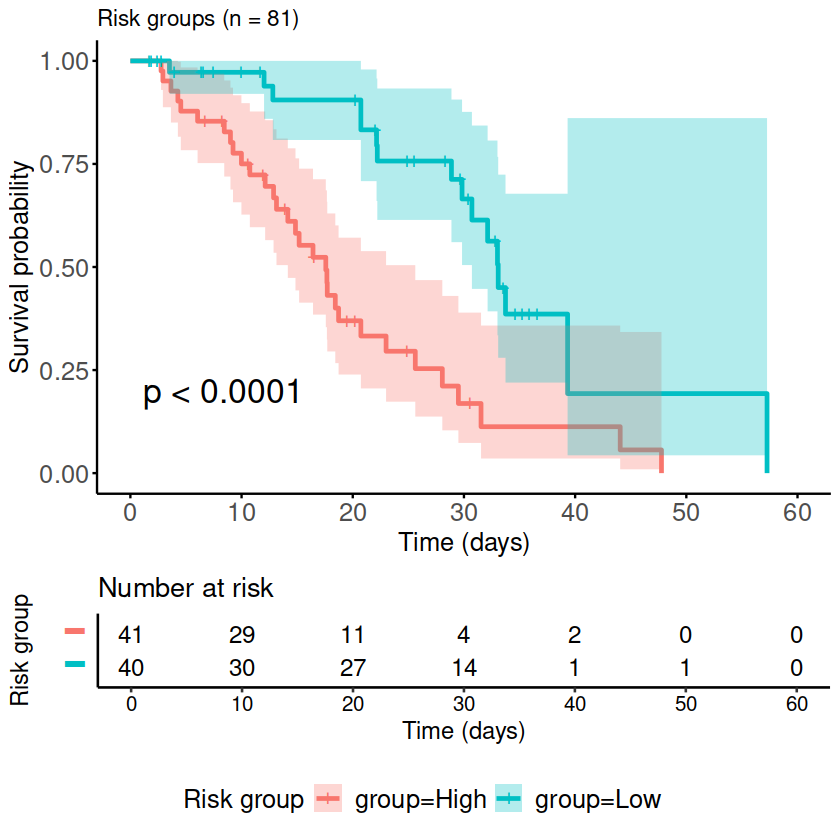

In [112]:
km.res.polya.005

In [113]:
# Write the results 
cox.res.table.polya.01 = tidy(cox.model.polya.005)
write.csv(cox.res.table.polya.01, file.path(out.dir, "PolyA_capture_cox_pvalueT_005.csv"))

# C-index
cindex.005 = cindex.polya.005$c.index
cindex.CI.005 = paste0(round(cindex.polya.005$lower,2), "-", round(cindex.polya.005$upper, 2))
C.index.df.polya.005 = data.frame(C.index = cindex.005,
                                  CI = cindex.CI.005)
write.csv(C.index.df.polya.005, file.path(out.dir, "PolyA_capture_Cindex_005.csv"))

# KM
ggsave(plot = km.res.polya.005$Plot$plot, 
       file.path(out.dir, "PolyA_capture_KM_005.pdf"))

Saving 6.67 x 6.67 in image



#### P-value threshold 0.2

In [114]:
cox.model.polya.02 = fitCoxModel(expression.data.polya.final, 
            end.point = "OS", 
            features = km.results.polya.table$Feature[km.results.polya.table$pval < 0.2])

In [115]:
cox.model.polya.02

Call:
coxph(formula = f, data = data)

             coef exp(coef) se(coef)      z       p
AURKB.exp -0.4012    0.6695   0.2992 -1.341 0.18002
KIF23.exp  0.8404    2.3172   0.3729  2.253 0.02424
AURKA.exp  0.2416    1.2733   0.3796  0.637 0.52444
TRAF6.exp -0.5897    0.5545   0.1818 -3.244 0.00118
MYC.exp    0.2089    1.2323   0.2092  0.999 0.31791

Likelihood ratio test=24.5  on 5 df, p=0.0001742
n= 81, number of events= 47 

In [116]:
# Predict based on model
rel.risk.polya.02 = predict(object = cox.model.polya.02)

In [117]:
# Prepare data
y.data.polya.02 = expression.data.polya.final %>% dplyr::select(OS, OS.time)
colnames(y.data.polya.02) = c("status","time")

In [118]:
# Calculate C-index
cindex.polya.02 = concordance.index(rel.risk.polya.02, 
                                     y.data.polya.02$time, 
                                     y.data.polya.02$status,
                                     na.rm = TRUE)

In [119]:
cindex.polya.02$c.index

[1] 0.7405583

In [120]:
# Plot KM
km.res.polya.02 = plotKMbyRelativeRisk(data = y.data.polya.02, 
                                     rel.risk = rel.risk.polya.02)

$Plot

$table
   N Pvalue.variable  Pvalue.pval Pvalue.method Pvalue.pval.txt
1 81           group 8.870009e-05      Log-rank      p < 0.0001


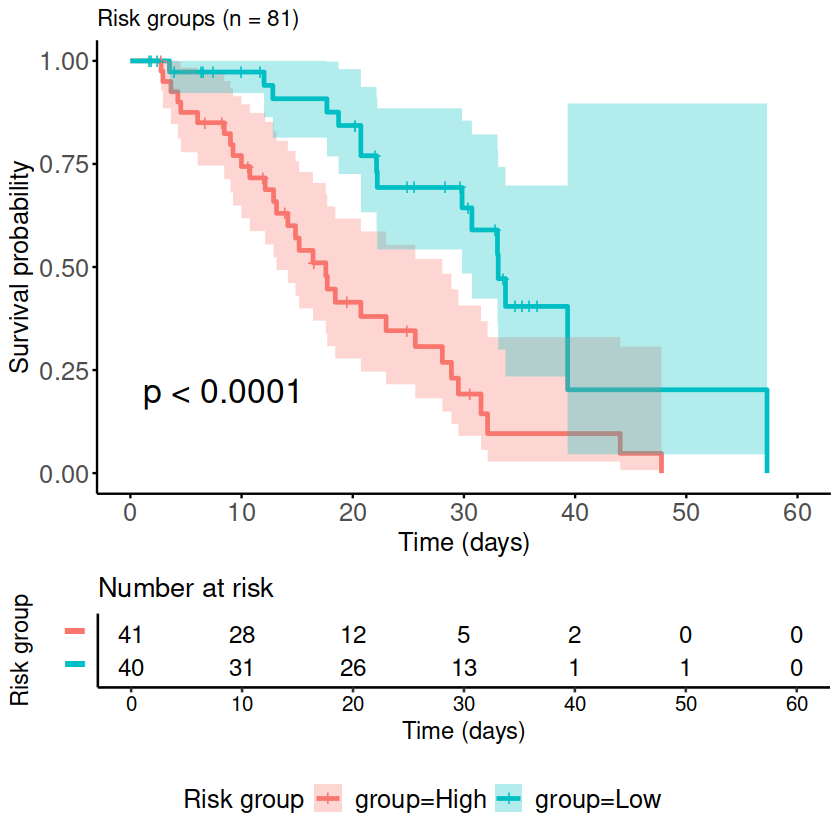

In [121]:
km.res.polya.02

In [122]:
# Write the results 
cox.res.table.polya.02 = tidy(cox.model.polya.02)
write.csv(cox.res.table.polya.02, file.path(out.dir, "PolyA_capture_cox_pvalueT_02.csv"))

# C-index
cindex.02 = cindex.polya.02$c.index
cindex.CI.02 = paste0(round(cindex.polya.02$lower,2), "-", round(cindex.polya.02$upper, 2))
C.index.df.polya.02 = data.frame(C.index = cindex.02,
                                  CI = cindex.CI.02)
write.csv(C.index.df.polya.02, file.path(out.dir, "PolyA_capture_Cindex_02.csv"))

# KM
ggsave(plot = km.res.polya.02$Plot$plot, 
       file.path(out.dir, "PolyA_capture_KM_02.pdf"))

Saving 6.67 x 6.67 in image



#### P-value threshold 0.3

In [123]:
cox.model.polya.03 = fitCoxModel(expression.data.polya.final, 
            end.point = "OS", 
            features = km.results.polya.table$Feature[km.results.polya.table$pval < 0.3])

In [124]:
cox.model.polya.03

Call:
coxph(formula = f, data = data)

             coef exp(coef) se(coef)      z        p
AURKB.exp -0.4134    0.6614   0.2963 -1.395 0.162899
KIF23.exp  0.9302    2.5350   0.3765  2.471 0.013491
AURKA.exp  0.2188    1.2446   0.3807  0.575 0.565404
TRAF6.exp -0.6345    0.5302   0.1876 -3.382 0.000721
MYC.exp    0.1758    1.1922   0.2176  0.808 0.418997
VPS4A.exp  0.3229    1.3812   0.1734  1.863 0.062479

Likelihood ratio test=28.14  on 6 df, p=8.833e-05
n= 81, number of events= 47 

Calculate C-index 

In [125]:
rel.risk.polya.03 = predict(object = cox.model.polya.03)

In [126]:
# Prepare data
y.data.polya.03 = expression.data.polya.final %>% dplyr::select(OS, OS.time)
colnames(y.data.polya.03) = c("status","time")

In [127]:
cindex.polya.03 = concordance.index(rel.risk.polya.03, 
                                     y.data.polya.03$time, 
                                     y.data.polya.03$status,
                                     na.rm = TRUE)

In [128]:
cindex.polya.03$c.index

[1] 0.7454844

In [129]:
# Plot KM
km.res.polya.03 = plotKMbyRelativeRisk(data = y.data.polya.03, 
                                     rel.risk = rel.risk.polya.03)

$Plot

$table
   N Pvalue.variable  Pvalue.pval Pvalue.method Pvalue.pval.txt
1 81           group 5.215971e-05      Log-rank      p < 0.0001


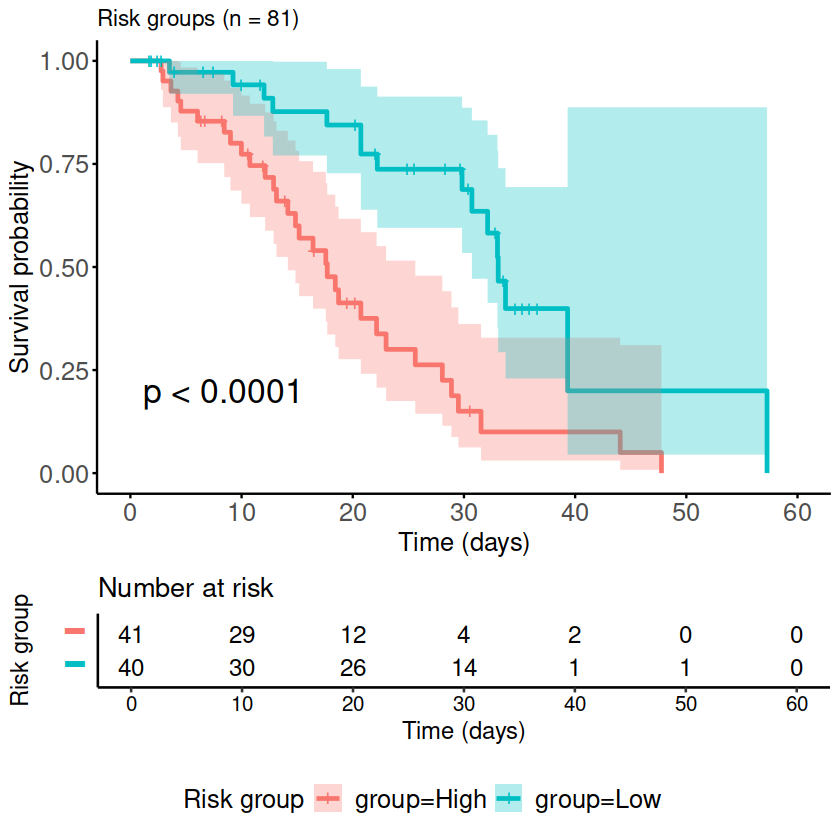

In [130]:
km.res.polya.03

In [131]:
# Write the results 
cox.res.table.polya.03 = tidy(cox.model.polya.03)
write.csv(cox.res.table.polya.03, file.path(out.dir, "PolyA_capture_cox_pvalueT_03.csv"))

# C-index
cindex.03 = cindex.polya.03$c.index
cindex.CI.03 = paste0(round(cindex.polya.03$lower,2), "-", round(cindex.polya.03$upper, 2))
C.index.df.polya.03 = data.frame(C.index = cindex.03,
                                  CI = cindex.CI.03)
write.csv(C.index.df.polya.03, file.path(out.dir, "PolyA_capture_Cindex_03.csv"))

# KM
ggsave(plot = km.res.polya.03$Plot$plot, 
       file.path(out.dir, "PolyA_capture_KM_03.pdf"))

Saving 6.67 x 6.67 in image

